# Modèle Q

## Tâche expérimentale

Dans cette tâche, deux machines à sous sont présentées à chaque essai, chacune associée à une certaine probabilité de récompense.  les probabilités de gain des machines A et B sont définie par nous, les expérimentateurs. Il y a tjours une "bonne" et une "mauvaise" option. La probabilité de gain lorsque le participants choisit la machine à forte rémunération est toujours de 80 %. La probabilité de récompense lorsque le participant choisit la machine à faible récompense n'était que de 30 %. La tâche est une Markovienne, cela signique que le retour d'information que vous obtenez dépend UNIQUEMENT de la machine à sous choisie (A ou B) et ne dépend donc pas de l'emplacement, ni des choix précédents.




## Code du modèle 

### Définition des variables "input"

Nous avons deux paramètres libres: 
- le taux d'apprentissage, noté comme alpha
- la température inverse, noté comme inv_temp

In [11]:
alpha      = 0.3;
inv_temp   = 1.5;

Nombre d'essais de la tâche

In [12]:
ntrials = 24;

Valeur initiale de deux machines à sous (A et B)

In [14]:
Q0  = [0 0]; % valeur initiale


Définir la possibilité d'obtenir une récompense pour chacun machine à sous :
- RA c'est les récompense pour la machine à sous A,  ce qui sera mis à 1 dans 80% des fois
- RB c'est les récompense pour la machine à sous B,  ce qui sera mis à 1 dans 20% des fois
- O combine les deux options en deux colonnes dans une matrice de "récompenses obtenables"

In [15]:
RA = rand(ntrials,1)<0.8;
RB = rand(ntrials,1)<0.2;
O = [RB, RA]

O = 24x2 logical array
   0   1
   0   1
   1   0
   0   1
   0   0
   0   1
   0   1
   0   1
   0   1
   0   1
   0   0
   0   1
   0   1
   0   0
   0   0
   0   1
   0   1
   1   1
   1   1
   0   1
   1   1
   0   1
   0   0
   0   1

### Initialisation des variables "output"

Nous allons initialiser des vecteurs vides dans lesquels les valeurs de chaque variable d'intérêt calculée par le modèle sont sauvées essai par essai.

In [16]:
Qt  = nan(ntrials+1, 2);    % valuer pour l'option B (col 1) et l'option A (col 2)
PE  = nan(ntrials, 1);      % Erreur de prediction
ch  = nan(ntrials, 1);      % choix : 1 = B; 2 = A
PA  = nan(ntrials, 1);      % probabilité de choisir A
r   = nan(ntrials, 1);      % récompense obtenue

### Excuter le modèle

Le modèle se base sur Rescorla-Wagner pour la mise à jour de la valeur de l'option choisie et sur softmax pour le calcul de la probabilité de choisir l'option avec la plus haute valeur.

Nous allons l'utiliser dans une boucle "for" qui va lire les essais un par un et exécuter les opérations suivantes :

1. **Calculer la probabilité de choisir A :** D'abord, il va calculer la probabilité de choisir l'option A en utilisant la fonction softmax (voir à la fin pour un approfodissement sur cette function).

$$
P_A(t) = \frac{1}{1 + e^{-\beta \cdot (Q_t(t,2) - Q_t(t,1))}}
$$


2. **Simuler le choix du modèle :** Ensuite, on simule le choix fait par le modèle (1 = B et 2 = A). On introduit un peu de stochasticité dans le choix en utilisant rand(). Si la probabilité de choisir A (entre 0 et 1) est plus grande qu'un nombre aléatoire entre 0 et 1, alors on choisit A (1+1), sinon on choisit B (1+0).

3. **Délivraison de la récompense :** La récompense est délivrée selon si une récompense est disponible dans la matrice des récompenses délivrables (O) et selon l'action (ch) qui a été faite (1 ou 2).

4. **Calculer de l'erreur de prédiction :** Différence entre valeur attendue et récompense observé

5. **Mise à de la valuer de l'option choisie :** Mis à jours de la valeur comme dans le modèle de Rescorla-Wagner.


In [18]:
Qt(1,:)  = Q0 ;             % initalise Q values

% value simulation
for t = 1:ntrials
    
    % 1 calculer la probabilté de choisr A
    PA(t)   = 1./(1+exp(-inv_temp.*(Qt(t,2)-Qt(t,1))));
    
    % 2 simuler le choix du modèle (1 = option B, 2 = option A)
    ch(t)   = 1 + double(rand()<PA(t));
    
    % 3 delivrer la récompense
    r(t)    = O(t,ch(t));
    
    % 4 compute prediction error
    PE(t)   = r(t) - Qt(t,ch(t));
    
    % 5 mise à jours de la valeur
    Qt(t+1,ch(t)) = Qt(t,ch(t)) + alpha.*PE(t);     % column ch(t) = chosen (1 or 2)
    Qt(t+1,3-ch(t)) = Qt(t,3-ch(t));                % column 3-ch(t) = unchosen (2 or 1)
    
end

Qt

Qt = 25x2 double
         0         0
         0    0.3000
         0    0.5100
    0.3000    0.5100
    0.3000    0.6570
    0.3000    0.4599
    0.2100    0.4599
    0.2100    0.6219
    0.2100    0.7354
    0.2100    0.8147
...

### Representations graphiques des trajectoires temporelles des variables latentes

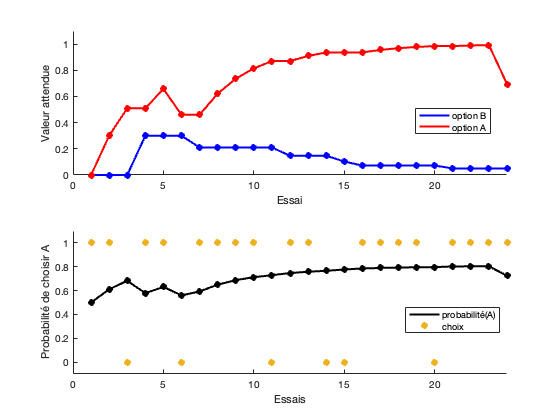

In [19]:
figure

% display the simulation results for predicted value
subplot(2, 1, 1)
hold on
valueA =  plot(Qt(:,1), '-b');
plot(Qt(:,1), 'ob', 'MarkerFaceColor', 'b');  % Points noirs pour chaque observation
valueB = plot(Qt(:,2), '-r');
plot(Qt(:,2), 'or', 'MarkerFaceColor', 'r');  % Points noirs pour chaque observation
set(valueA, 'LineWidth', 2);
set(valueB, 'LineWidth', 2);

xlim([0, ntrials]);
ylim([0, 1.1]);
xlabel('Essai');
ylabel('Valeur attendue');
legend([valueA, valueB],'option B','option A','Location','best');

% display the simulation results for probability of choosing A
subplot(2, 1, 2);
hold on
pro = plot(PA, '-k');
plot(PA, 'ok', 'MarkerFaceColor', 'k');  % Points noirs pour chaque observation
set(pro, 'LineWidth', 2);
ch = plot(ch-1, 'o','MarkerFaceColor', [0.9290 0.6940 0.1250]);  % Points noirs pour chaque observation);
xlim([0, ntrials]);
ylim([-0.1, 1.1]);
xlabel('Essais');
ylabel('Probabilité de choisir A');
legend([pro,ch],'probabilité(A)','choix','Location','best');


### Approfodissement sur la function softmax

Au début de chaque essai, le participant doit décider, sur la base de deux valeurs (Q de la machine à sous A et Q de la machine à sous B), quelle machine choisir? Il y a deux options:

- toujours choisir le stimulus ayant la valeur la plus élevée
- parfois chercher à savoir si l'autre machine s'est améliorée

Même si la première option conduit à la plus grande récompense, les individus ne utilisent généralement pas cette stratégie de "maximisation de la probabilité" (c'est-à-dire choisir le stimulus avec la plus grande probabilité de récompense). Ils choisissent plutôt le stimulus ayant la probabilité la plus élevée, mais pas tout le temps, de tans en tans ils explorent l'autre option.
Cependant, il y a des différences interindividuelles dans la mésure ou les individuent explorent. Pour modéliser la manière dont les individus traduisent les valeurs apprises en un choix, nous utiliserons un modèle capable de rendre compte de ces différentes stratégies avec la function softmax. 

Dans le cas notre tâche experimentale softmax calcule la probabilité de choisir A étant donné la valuer de la machine à sous A ($Q_A$) et la valeur de la machine à sous B ($Q_B$) comme il suit: 


$$
p(A) = \frac{e^{\beta \cdot Q_A}}{e^{\beta \cdot Q_A} + e^{\beta \cdot Q_B}} 
$$


Ou

- $\beta$ est le paramètre de température inverse, qui contrôle le niveau d'exploration 
- $Q_B$ est la valeur associée à la machine à sous B.


Dans le code nous allons formuler softmax comme il suit:

$$ 
P_A(t) = \frac{1}{1 + e^{-\beta \cdot (Q_t(t,2) - Q_t(t,1))}} 
$$

Allons maitentant voir cocrètement l'imapact du parametre sur la probabilité de choisir nous allons définir trois valuers de $\beta$

In [127]:
betaArray = [1 3 10];

In [ ]:
Nous allons en suite définir des valeur de A et B

In [128]:
QA = 0:0.02:1;
QB = 1 - QA;


In [ ]:
Ensuite nous allons initialiser les variables pour le graphiques

In [120]:
PA   = nan(length(betaArray),length(QA));   % probablité de choisir A
ct   = 0;   % compteur pour le "loop for"
x    = .02; % parametre pour le graphique
leg  = {};

In [121]:
% calcule des la probabilté de choisir pour chaqu'un des valuers de beta (noté comme inv_temp)
for inv_temp  = betaArray 
    
    ct = ct+1;
    
    PA(ct,:) = 1./(1+exp(-inv_temp.*(QA-QB))); % calculate la probabilité de choisir A
    
    leg{ct}  = sprintf('beta = %d', inv_temp) ; % emprimer la valeur de beta choisit pour la legende du graphique
    
end


Finalement nous allons emprimer le graphique et visualiser l'impact de $ \beta $ sur la probabilité de choisir la slot machine A

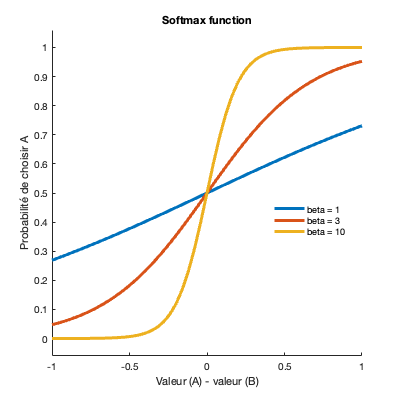

In [129]:
h = figure; set(h,'position',[10 60 400 400 ],'Color','w'); 
hold on; box off; 


sig = plot(QA-QB,PA);
set(sig, 'LineWidth', 3);

xlabel('Valeur (A) - valeur (B)');
ylabel('Probabilité de choisir A');
title(sprintf('Softmax function'));
ylim([-x*ct 1+x*ct]);
legend(leg,'location','best'); legend boxoff;